# Dimension and Information Loss

We measure dimensionality vs information loss in various ways. 

TODO: 
1) Datasets: time series datasets (logistic map, chaotic attractors), image datasets (MNIST), manifold (swiss roll with extra dimensions)
2) Embedding algos: takens (TS), PCA, MLP-AE, CNN-AE, etc.
3) measure I(X,Y), reconstruciton loss (MSE/NMSE), loss in predictive power (f(x) vs. f(x_compressed)), etc. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def logistic_map(r, x_0, max_iter = 1000): 
    traj = [x_0]

    for i in range(1, max_iter): 
        x = r * traj[i-1] * (1-traj[i-1])
        traj.append(x)

    return traj

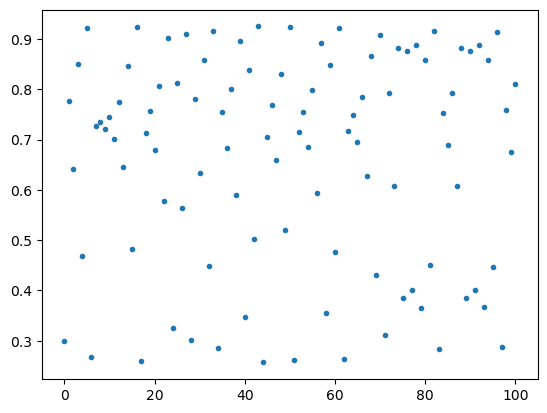

In [8]:
plt.plot(logistic_map(3.7, 0.3, 100), '.')